In [1]:
%%capture
!pip install transformers torch seqeval


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torch.nn.modules.module")

# Hybrid Model: AraBERT + BiLSTM
# AraBERT: Transfer Learning (RL) --- > # Freeze weights
# Labels (BIO Model): B (Begin), I (Inside), O (Outside)
class BERT_BiLSTM_TokenClassifier(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, num_labels, dropout=0.3):
        super(BERT_BiLSTM_TokenClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            bidirectional=True,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        lstm_output = self.dropout(lstm_output)
        logits = self.classifier(lstm_output)
        return logits

# Parameters
bert_model_name = "aubmindlab/bert-base-arabertv2"
hidden_dim = 128
num_labels = 3 # --- > 3 classes

# Build the Model
model = BERT_BiLSTM_TokenClassifier(bert_model_name, hidden_dim, num_labels)

def count_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return f"Total: {total:,} | Trainable: {trainable:,}"

print(count_parameters(model))
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
tokens = tokenizer("وذهبتُ إلى المدرسة", return_tensors="pt", padding=True, truncation=True)
logits = model(tokens["input_ids"], tokens["attention_mask"])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Total: 136,113,667 | Trainable: 136,113,667


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Creating Synthetic Dataset

In [14]:
bert_model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
df = pd.read_csv("/content/sentences.csv", encoding="utf-8")
print(f"df shape: {df.shape}\ndf columns: {df.columns}\ndf max_id, min_id: {df.index[0], df.index[-1]}\ndf's label freq: {df['label'].value_counts()}")
print('='*40)
print(df.head(3))
print('='*40)
final_df = df.sort_values(['sentence_id']).reset_index(drop=True)
final_df['sentence_id'] = final_df['sentence_id'].rank(method='dense').astype(int)
print(f"Are the whole sentences uniqely generated? must be 700 sentences: {final_df['sentence_id'].nunique()}\n")
print(f"The least id number = {final_df['sentence_id'].min()}\nThe last id number = {final_df['sentence_id'].max()}\n")
print('='*40)
sen = []
label__ = []
for sentence_id, group in final_df.groupby('sentence_id'):
    sen.append(group['token'].tolist())
    label__.append(group['label'].tolist())
print(f"In the final dataset, the number of total sentences are = {len(sen)}\tand the number of labels are = {len(label__)}")
print(f"The {len(sen)} sentences comprises with {final_df.index.max()} tokens")
print("Example sample: \n", sen[0])
print(label__[0])

df shape: (5686, 3)
df columns: Index(['sentence_id', 'token', 'label'], dtype='object')
df max_id, min_id: (0, 5685)
df's label freq: label
B    2237
E    1495
I     697
S     657
O     600
Name: count, dtype: int64
   sentence_id token label
0            1    جل     B
1            1     س     E
2            1    ال     B
Are the whole sentences uniqely generated? must be 700 sentences: 700

The least id number = 1
The last id number = 700

In the final dataset, the number of total sentences are = 700	and the number of labels are = 700
The 700 sentences comprises with 5685 tokens
Example sample: 
 ['جل', 'س', 'ال', 'معلم', '!', 'ال', 'جامع', 'ة', '،']
['B', 'E', 'B', 'E', 'O', 'B', 'I', 'E', 'O']


In [16]:
sentences = sen
labels = label__
# Splitting: 80/20
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

# Encoding
all_tags = sorted(list(set([tag for label_list in labels for tag in label_list])))
label_encoder = LabelEncoder()
label_encoder.fit(all_tags)
label2id = {l: i for i, l in enumerate(label_encoder.classes_)}
id2label = {i: l for l, i in label2id.items()}
tokenized_inputs = []
encoded_labels = []

for words, lbls in zip(sentences, labels):
    sentence = " ".join(words)
    encoding = tokenizer(sentence, truncation=True, padding='max_length', max_length=20, return_tensors="pt")
    word_ids = tokenizer(sentence).word_ids()

    label_ids = []
    previous_word = None
    for word_id in word_ids:
        if word_id is None:
            label_ids.append(-100)
        elif word_id != previous_word:
            label_ids.append(label2id[lbls[word_id]])
            previous_word = word_id
        else:
            label_ids.append(label2id["I"])

    while len(label_ids) < encoding["input_ids"].shape[1]:
        label_ids.append(-100)
    if len(label_ids) > encoding["input_ids"].shape[1]:
        label_ids = label_ids[:encoding["input_ids"].shape[1]]

    tokenized_inputs.append((encoding["input_ids"], encoding["attention_mask"]))
    encoded_labels.append(torch.tensor(label_ids))



def encode_data(sentences, labels, tokenizer, label2id, max_length=20):
    tokenized_inputs = []
    encoded_labels = []

    for words, lbls in zip(sentences, labels):
        sentence = " ".join(words)
        encoding = tokenizer(sentence, truncation=True, padding='max_length', max_length=max_length, return_tensors="pt")
        word_ids = tokenizer(sentence).word_ids()

        label_ids = []
        previous_word = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != previous_word:
                label_ids.append(label2id[lbls[word_id]])
                previous_word = word_id
            else:
                label_ids.append(label2id["I"])

        while len(label_ids) < encoding["input_ids"].shape[1]:
            label_ids.append(-100)
        if len(label_ids) > encoding["input_ids"].shape[1]:
            label_ids = label_ids[:encoding["input_ids"].shape[1]]

        tokenized_inputs.append((encoding["input_ids"], encoding["attention_mask"]))
        encoded_labels.append(torch.tensor(label_ids))

    return tokenized_inputs, encoded_labels

train_inputs, train_enc_labels = encode_data(train_sentences, train_labels, tokenizer, label2id)
test_inputs, test_enc_labels = encode_data(test_sentences, test_labels, tokenizer, label2id)

print("-"*40)
print("sentence: \n\t>>>", sentences[0])
print("label: \n\t>>>", labels[0])
print("Input IDs:", tokenized_inputs[0][0])
print("Attention Mask:", tokenized_inputs[0][1])
print("Label IDs:", encoded_labels[0])
print("label2id:", label2id)
print("-"*20, "\tTrain/Test size\t","-"*20)
print(f"train size: {len(train_inputs)}")
print(f"test size: {len(test_inputs)}")
print(f"train label size: {len(train_enc_labels)}")
print(f"test label size: {len(test_enc_labels)}")

----------------------------------------
sentence: 
	>>> ['جل', 'س', 'ال', 'معلم', '!', 'ال', 'جامع', 'ة', '،']
label: 
	>>> ['B', 'E', 'B', 'E', 'O', 'B', 'I', 'E', 'O']
Input IDs: tensor([[  33, 1909,  151,  288, 2093,   36,  288,  785,  141,  130,   34,   31,
           31,   31,   31,   31,   31,   31,   31,   31]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Label IDs: tensor([-100,    0,    1,    0,    1,    3,    0,    2,    1,    3, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100])
label2id: {np.str_('B'): 0, np.str_('E'): 1, np.str_('I'): 2, np.str_('O'): 3, np.str_('S'): 4}
-------------------- 	Train/Test size	 --------------------
train size: 560
test size: 140
train label size: 560
test label size: 140


`# Train Phase`

Epoch 1/100 | Loss: 1.5462 | Acc: 0.2951 | Prec: 0.1617 | Rec: 0.1871 | F1: 0.1344
Epoch 2/100 | Loss: 1.4028 | Acc: 0.4010 | Prec: 0.2354 | Rec: 0.2153 | F1: 0.1426
Epoch 3/100 | Loss: 1.3244 | Acc: 0.4590 | Prec: 0.2670 | Rec: 0.2601 | F1: 0.2030
Epoch 4/100 | Loss: 1.2941 | Acc: 0.4856 | Prec: 0.3155 | Rec: 0.2857 | F1: 0.2321
Epoch 5/100 | Loss: 1.2483 | Acc: 0.4998 | Prec: 0.3037 | Rec: 0.3075 | F1: 0.2750
Epoch 6/100 | Loss: 1.2049 | Acc: 0.5299 | Prec: 0.3078 | Rec: 0.3460 | F1: 0.3196
Epoch 7/100 | Loss: 1.1762 | Acc: 0.5469 | Prec: 0.3214 | Rec: 0.3661 | F1: 0.3367
Epoch 8/100 | Loss: 1.1396 | Acc: 0.5572 | Prec: 0.3313 | Rec: 0.3751 | F1: 0.3460
Epoch 9/100 | Loss: 1.0985 | Acc: 0.5744 | Prec: 0.3484 | Rec: 0.3932 | F1: 0.3610
Epoch 10/100 | Loss: 1.0660 | Acc: 0.5807 | Prec: 0.6910 | Rec: 0.4026 | F1: 0.3684
Epoch 11/100 | Loss: 1.0362 | Acc: 0.5999 | Prec: 0.7693 | Rec: 0.4198 | F1: 0.3858
Epoch 12/100 | Loss: 0.9889 | Acc: 0.6221 | Prec: 0.7418 | Rec: 0.4419 | F1: 0.4130
E

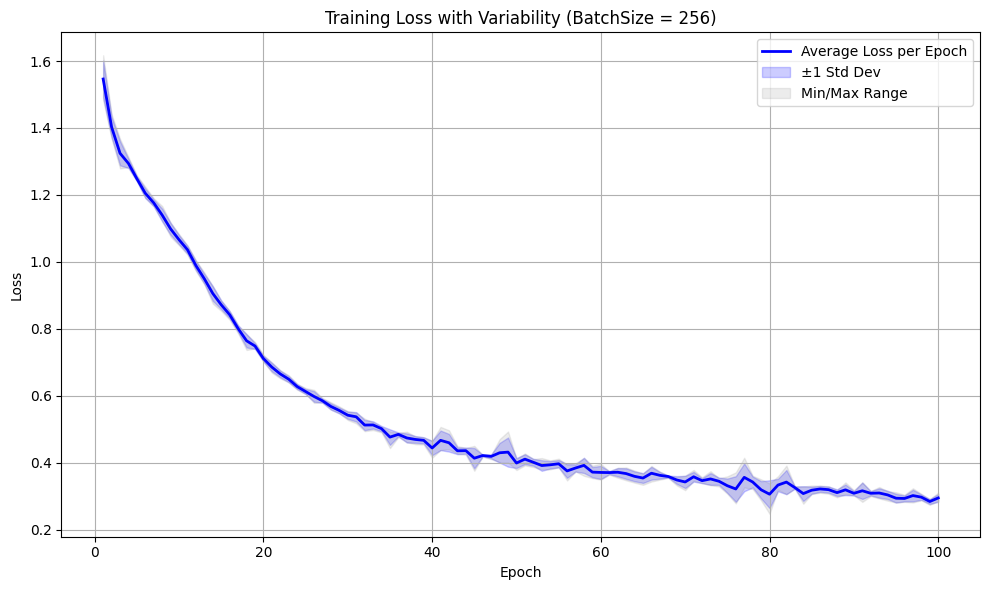

In [57]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning, module="torch.nn.modules.module")

class TokenDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_ids, attention_mask = self.inputs[idx]
        label_ids = self.labels[idx]
        return {
            "input_ids": input_ids.squeeze(0),
            "attention_mask": attention_mask.squeeze(0),
            "labels": label_ids
        }

class BERT_BiLSTM_TokenClassifier(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, num_labels, dropout=0.3, batch_size=4):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            bidirectional=True,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

        self.batch_size = batch_size
        self.epoch_losses, self.epoch_accuracies = [], []
        self.epoch_precisions, self.epoch_recalls, self.epoch_f1s = [], [], []
        self.batch_losses_per_epoch, self.val_losses = [], []
        self.Final = {}

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        seq = outputs.last_hidden_state
        lstm_out, _ = self.lstm(seq)
        logits = self.classifier(self.dropout(lstm_out))
        return logits

    @torch.no_grad()
    def evaluate_loss(self, dataloader, loss_fn, device):
        self.eval()
        total = 0.0
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            logits = self(input_ids, attention_mask)
            loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
            total += loss.item()
        return total / max(1, len(dataloader))

    def update(self, avg_loss, batch_losses, accuracy=None, precision=None, recall=None, f1=None):
        self.epoch_losses.append(avg_loss)
        self.batch_losses_per_epoch.append(batch_losses)
        self.epoch_accuracies.append(accuracy)
        self.epoch_precisions.append(precision)
        self.epoch_recalls.append(recall)
        self.epoch_f1s.append(f1)

    def train_model(self, train_loader, val_loader=None, epochs=3, lr=2e-5, device=None):
        device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            self.train()
            total_loss, batch_losses = 0.0, []
            all_preds, all_labels = [], []

            for batch in train_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                optimizer.zero_grad()
                logits = self(input_ids, attention_mask)
                loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
                loss.backward()
                optimizer.step()

                val = loss.item()
                total_loss += val
                batch_losses.append(val)

                preds = torch.argmax(logits, dim=-1).detach().cpu().numpy().reshape(-1)
                target = labels.detach().cpu().numpy().reshape(-1)
                valid = target != -100
                all_preds.extend(preds[valid])
                all_labels.extend(target[valid])

            avg_loss = total_loss / max(1, len(train_loader))
            acc = accuracy_score(all_labels, all_preds)
            prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
            rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
            f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

            if val_loader is not None:
                val_loss = self.evaluate_loss(val_loader, loss_fn, device)
                self.val_losses.append(val_loss)
                print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Val: {val_loss:.4f} | "
                      f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | "
                      f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

            self.update(avg_loss, batch_losses, acc, prec, rec, f1)
            self.Final[epoch] = [avg_loss, acc, prec, rec, f1]
        return self.Final

    def plot_loss_with_variation(self):
        epochs = np.arange(1, len(self.epoch_losses) + 1)
        means = np.array(self.epoch_losses)
        stds = np.array([np.std(b) for b in self.batch_losses_per_epoch])
        mins = np.array([np.min(b) for b in self.batch_losses_per_epoch])
        maxs = np.array([np.max(b) for b in self.batch_losses_per_epoch])
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, means, color="blue", label="Average Loss per Epoch", linewidth=2)
        plt.fill_between(epochs, means - stds, means + stds, color="blue", alpha=0.2, label="±1 Std Dev")
        plt.fill_between(epochs, mins, maxs, color="gray", alpha=0.15, label="Min/Max Range")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Training Loss with Variability (BatchSize = {self.batch_size})")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        # plt.show()
        plt.savefig("loss_phase1.svg", dpi=1300)

    def plot_all_metrics(self):
        epochs = np.arange(1, len(self.epoch_losses) + 1)
        plt.figure(figsize=(12, 8))
        # Loss
        plt.plot(epochs, self.epoch_losses, label="Loss", color="red", linewidth=2, marker='o')
        # Accuracy
        plt.plot(epochs, self.epoch_accuracies, label="Accuracy", color="green", linewidth=2, marker='s')
        # Precision
        plt.plot(epochs, self.epoch_precisions, label="Precision", color="blue", linewidth=2, marker='^')
        # Recall
        plt.plot(epochs, self.epoch_recalls, label="Recall", color="orange", linewidth=2, marker='d')
        # F1
        plt.plot(epochs, self.epoch_f1s, label="F1 Score", color="purple", linewidth=2, marker='*')
        plt.xlabel("Epoch")
        plt.ylabel("Metric Value")
        plt.title(f"Training Metrics Over Epochs (BatchSize = {self.batch_size})")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig("all_metrics.svg", dpi=1300)
        plt.show()

    def evaluate_loss(self, model, dataloader, loss_fn, device=None):
        model.eval()
        total_val_loss = 0
        device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask)
                outputs = outputs.view(-1, outputs.shape[-1])
                labels = labels.view(-1)

                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(dataloader)
        return avg_val_loss

    def plot_train_val_loss(train_losses, val_losses):
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
        plt.title("Training vs Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# -------------------------------------------------------------------------------
train_dataset = TokenDataset(train_inputs, train_enc_labels)
train_loader  = DataLoader(train_dataset, batch_size=256, shuffle=True)
hidden_dim  = 128
num_labels  = len(label2id)
epochs      = 100
model = BERT_BiLSTM_TokenClassifier(bert_model_name, hidden_dim, num_labels, batch_size=256)
f = model.train_model(train_loader, val_loader=None, epochs=epochs, lr=2e-5)

model.plot_loss_with_variation()


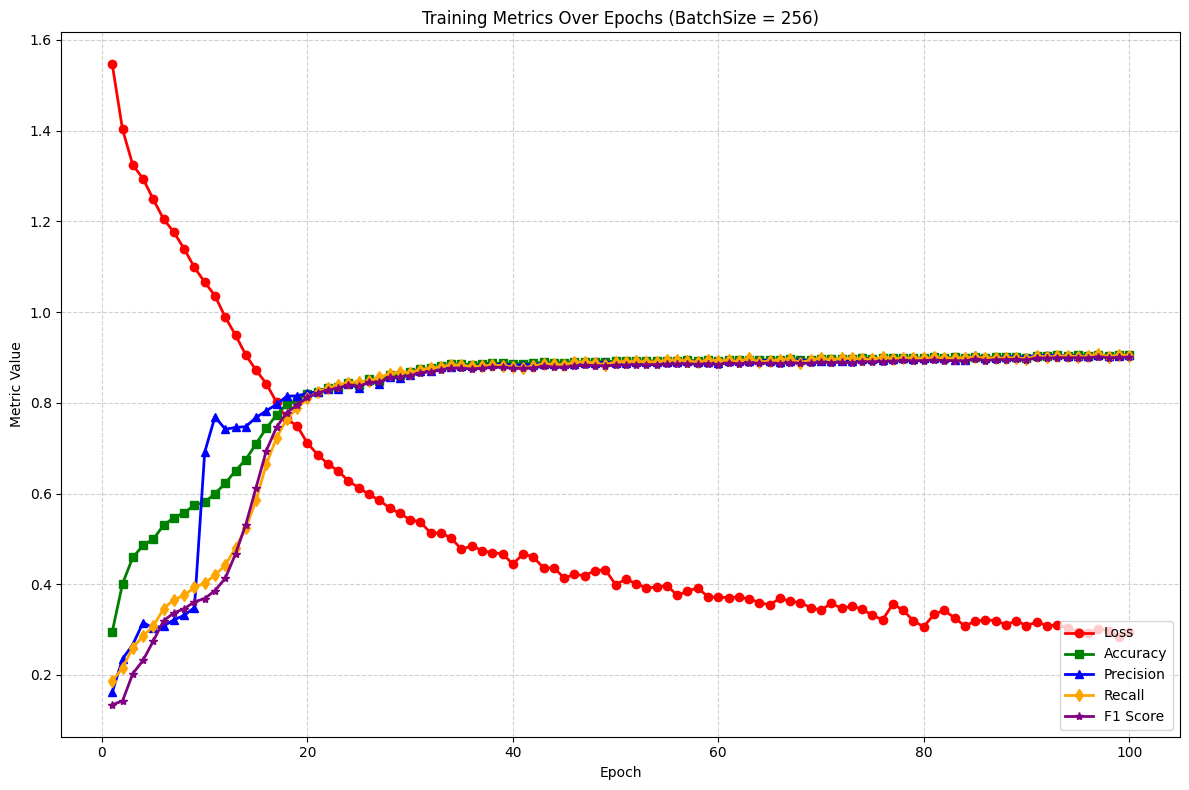

0.2515522887309392

In [58]:
model.plot_all_metrics()
model.evaluate_loss(model, train_loader, loss_fn)

<Axes: title={'center': 'F1'}>

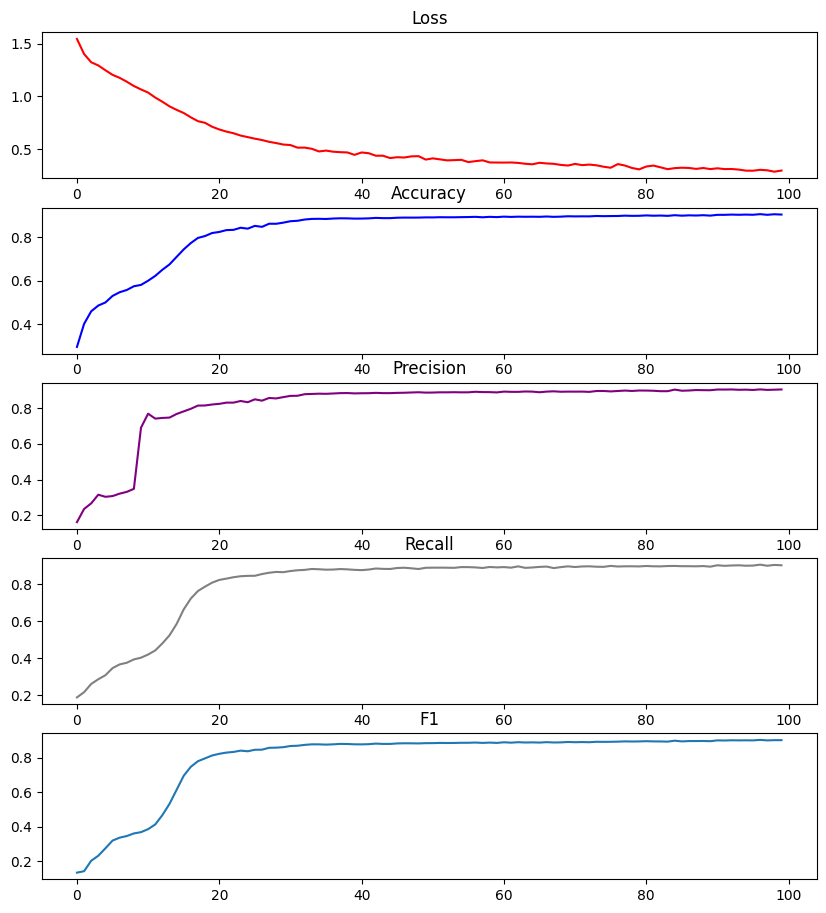

In [61]:
_df_ = pd.DataFrame(f)
_df_ = _df_.T
_df_.columns = ["Loss", "Acc", "Prec", "Rec", "F1"]
fig, ax = plt.subplots(5, 1, figsize=(10, 11))
_df_['Loss'].plot(kind='line', ax=ax[0], title='Loss', c='r')
_df_['Acc'].plot(kind='line', ax=ax[1], title='Accuracy', c='b')
_df_['Prec'].plot(kind='line', ax=ax[2], title='Precision', c='purple')
_df_['Rec'].plot(kind='line', ax=ax[3], title='Recall', c='gray')
_df_['F1'].plot(kind='line', ax=ax[4], title='F1')

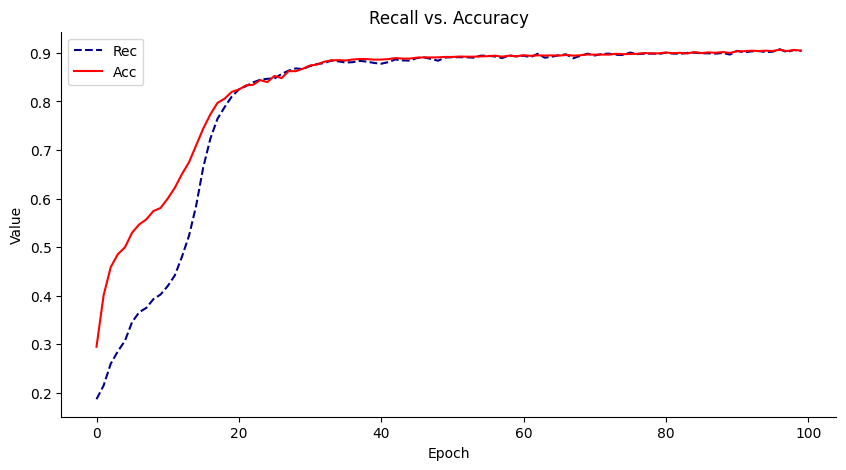

In [62]:
_df_['Rec'].plot(kind='line', c='darkblue', linestyle='--', title='Rec')
_df_['Acc'].plot(kind='line', c='r',figsize=(10, 5), title='Recall vs. Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
# plt.show()
plt.savefig("recall_acc_phase1.svg", dpi=1300)

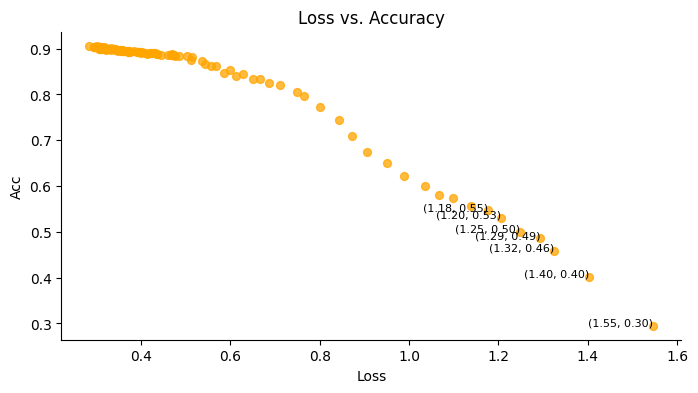

In [70]:
_df_.plot(kind='scatter', x='Loss', y='Acc', s=32, alpha=.75, c='orange', figsize=(8, 4), title='Loss vs. Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

for i in range(min(7, len(_df_))):
    loss_val = _df_['Loss'].iloc[i]
    acc_val = _df_['Acc'].iloc[i]
    plt.text(loss_val, acc_val, f'({loss_val:.2f}, {acc_val:.2f})', fontsize=8, ha='right')

# plt.show()
plt.savefig("loss_acc_phase1.svg", dpi=1300)